In [1]:
import os
os.getcwd()
os.chdir("G:/OneDrive/casa0010dissertation/00_06 jaipur code_mgwr")

In [2]:
import geopandas as gpd
from pathlib import Path
import pandas as pd
from shapely.ops import unary_union
import matplotlib.pyplot as plt
import osmnx as ox
import warnings
warnings.filterwarnings('ignore')

In [3]:
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['font.size'] = 12
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12

In [4]:
# Load the city boundary
aoi = gpd.read_file('data/raw/JMC_union.geojson')

In [5]:
aoi.crs

<Projected CRS: EPSG:32643>
Name: WGS 84 / UTM zone 43N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Between 72°E and 78°E, northern hemisphere between equator and 84°N, onshore and offshore. China. India. Kazakhstan. Kyrgyzstan. Maldives. Pakistan. Russian Federation. Tajikistan. Uzbekistan.
- bounds: (72.0, 0.0, 78.0, 84.0)
Coordinate Operation:
- name: UTM zone 43N
- method: Transverse Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [6]:
# Transform to the desired CRS EPSG_4326 which is required by OSMnx
aoi = aoi.to_crs(epsg=4326)

In [7]:
# Polygon for clipping
polygon = aoi.geometry.iloc[0]

# 1 Road Network Data Download

In [8]:
# Highway tags ordered by functional importance
highway_list = [
    "motorway", "motorway_link",
    "trunk", "trunk_link",
    "primary", "primary_link",
    "secondary", "secondary_link",
    "tertiary", "tertiary_link",
    "unclassified",
    "residential"
]

# Custom Overpass filter built from the list above
custom_filter = f'["highway"~"^({"|".join(highway_list)})$"]'

# Build the drivable street graph inside the AOI
G = ox.graph_from_polygon(
        polygon,
        network_type="drive",
        retain_all=False,
        truncate_by_edge=True,
        custom_filter=custom_filter
    )

In [9]:
edges = ox.graph_to_gdfs(G, nodes=False, edges=True)

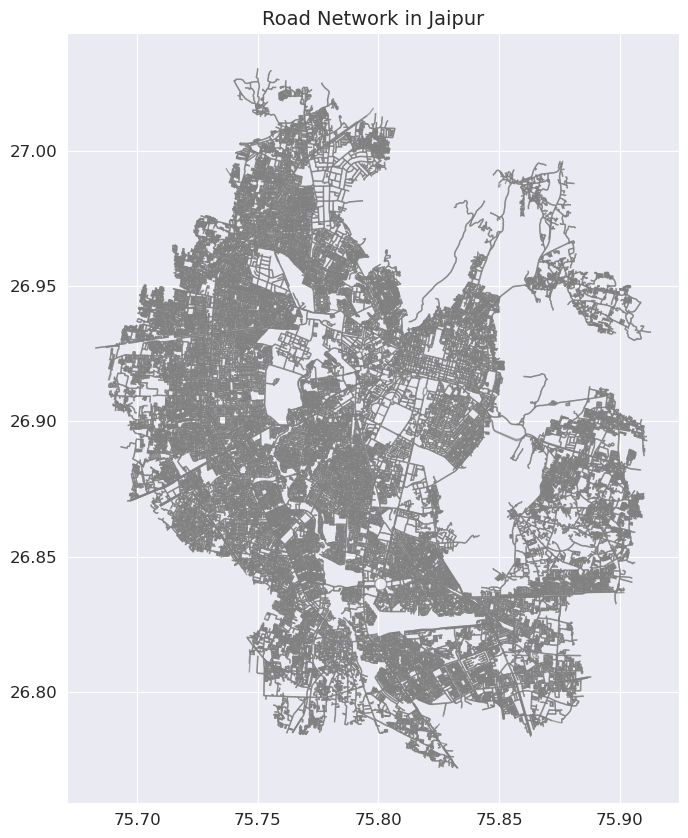

In [10]:
# plot the edges
fig, ax = plt.subplots(figsize=(10, 10))
edges.plot(ax=ax, linewidth=1, edgecolor='gray', alpha=0.7)
ax.set_title("Road Network in Jaipur")
plt.savefig('image/process/02_01 raw_road_network_jaipur.png', dpi=300, bbox_inches='tight')
plt.show()

In [11]:
edges.head(5)

osmid      highway lanes  oneway   ref  \
u         v           key                                               
245753419 11209773784 0    375205091        trunk     4    True  NH52   
315733696 2106291633  0    200664186        trunk   NaN   False   NaN   
          10129981494 0    200664186        trunk   NaN   False   NaN   
          317399857   0    932345036  residential   NaN   False   NaN   
315733698 6728974119  0    716049190   trunk_link   NaN    True   NaN   

                          reversed      length       name  \
u         v           key                                   
245753419 11209773784 0      False   45.839248        NaN   
315733696 2106291633  0       True   53.744358  Agra Road   
          10129981494 0      False   89.357876  Agra Road   
          317399857   0       True  120.955162        NaN   
315733698 6728974119  0      False   83.080847        NaN   

                                                                    geometry  \
u         v           key                                                      
245753419 11209773784 0    LINESTRING (75.79916 26.81619, 75.79941 26.81584)   
315733696 2106291633  0    LINESTRING (75.83842 26.90878, 75.83884 26.90847)   
          10129981494 0    LINESTRING (75.83842 26.90878, 75.83792 26.909...   
          317399857   0    LINESTRING (75.83842 26.90878, 75.83835 26.908...   
315733698 6728974119  0    LINESTRING (75.84217 26.90635, 75.84228 26.906...   

                          tunnel junction maxspeed access bridge width service  
u         v           key                                                       
245753419 11209773784 0      NaN      NaN      NaN    NaN    NaN   NaN     NaN  
315733696 2106291633  0      NaN      NaN      NaN    NaN    NaN   NaN     NaN  
          10129981494 0      NaN      NaN      NaN    NaN    NaN   NaN     NaN  
          317399857   0      NaN      NaN      NaN    NaN    NaN   NaN     NaN  
315733698 6728974119  0      NaN      NaN      NaN    NaN    NaN   NaN     NaN

In [12]:
# Transform to Jaipur's CRS EPSG:32643 and export to GeoJSON
edges = edges.to_crs(epsg=32643)
edges.to_file('data/raw/pca/road_network_jaipur.geojson', driver='GeoJSON')


# 2 Amenities Data Download

In [13]:
amenity_tag = {"amenity": True}

amenities = ox.features.features_from_polygon(polygon, tags=amenity_tag)

In [14]:
# Add geometry-type column (Point, Polygon, MultiPolygon …)
amenities["geom_type"] = amenities.geometry.geom_type

print("\nGeometry type counts:")
print(amenities["geom_type"].value_counts(dropna=False))


Geometry type counts:
geom_type
Point         1732
Polygon        373
LineString       3
Name: count, dtype: int64


In [15]:
def to_point(geom):
    """
    Convert any geometry to a representative point.
    - Point: returned unchanged
    - Polygon/MultiPolygon: shapely.representative_point() (always inside the area)
    - LineString/MultiLineString: midpoint via interpolate(0.5, normalized=True)
    - Other or empty: returns None (will be dropped)
    """
    if geom.is_empty:
        return None
    gtype = geom.geom_type
    if gtype == "Point":
        return geom
    elif gtype in ("Polygon", "MultiPolygon"):
        return geom.representative_point()
    elif gtype in ("LineString", "MultiLineString"):
        # Mid-point for lines
        try:
            return geom.interpolate(0.5, normalized=True)
        except Exception:
            return geom.centroid
    else:
        return geom.centroid

In [16]:
# # Preserve original geometry for reference
# amenities["orig_geom"] = amenities.geometry

# Apply conversion
amenities["geometry"] = amenities.geometry.apply(to_point)

# Drop rows where conversion failed
amenities = amenities[amenities.geometry.notnull()].set_geometry("geometry")

In [17]:
amenities.head(5)

geometry           amenity  \
element id                                                       
node    566811986  POINT (75.80354 26.91731)       post_office   
        566815183  POINT (75.82549 26.92336)       post_office   
        566815520  POINT (75.81098 26.91619)        restaurant   
        566816109  POINT (75.85229 26.91712)  place_of_worship   
        691261875  POINT (75.79857 26.91068)        restaurant   

                                           name diet:vegetarian alt_name  \
element id                                                                 
node    566811986              Central Post GPO             NaN      NaN   
        566815183                    Post Bazar             NaN      NaN   
        566815520  Natraj vegetarian Restaurant            only      NaN   
        566816109           Sun Temple , JAIPUR             NaN      NaN   
        691261875                   Anokhi Cafe             NaN      NaN   

                  name:zh  bus name:en operator public_transport  ...  \
element id                                                        ...   
node    566811986     NaN  NaN     NaN      NaN              NaN  ...   
        566815183     NaN  NaN     NaN      NaN              NaN  ...   
        566815520     NaN  NaN     NaN      NaN              NaN  ...   
        566816109     NaN  NaN     NaN      NaN              NaN  ...   
        691261875     NaN  NaN     NaN      NaN              NaN  ...   

                  fuel:cng capacity:disabled park_ride drinking_water  \
element id                                                              
node    566811986      NaN               NaN       NaN            NaN   
        566815183      NaN               NaN       NaN            NaN   
        566815520      NaN               NaN       NaN            NaN   
        566816109      NaN               NaN       NaN            NaN   
        691261875      NaN               NaN       NaN            NaN   

                  fountain height name:bn leisure seasonal geom_type  
element id                                                            
node    566811986      NaN    NaN     NaN     NaN      NaN     Point  
        566815183      NaN    NaN     NaN     NaN      NaN     Point  
        566815520      NaN    NaN     NaN     NaN      NaN     Point  
        566816109      NaN    NaN     NaN     NaN      NaN     Point  
        691261875      NaN    NaN     NaN     NaN      NaN     Point  

[5 rows x 205 columns]

In [18]:

print(f"Number of records of amenities: {amenities.shape[0]}")

Number of records of amenities: 2108


In [19]:
# # Drop the 'orig_geom' column
# amenities = amenities.drop(columns=["orig_geom"])

In [20]:
amenities.columns

Index(['geometry', 'amenity', 'name', 'diet:vegetarian', 'alt_name', 'name:zh',
       'bus', 'name:en', 'operator', 'public_transport',
       ...
       'fuel:cng', 'capacity:disabled', 'park_ride', 'drinking_water',
       'fountain', 'height', 'name:bn', 'leisure', 'seasonal', 'geom_type'],
      dtype='object', length=205)

In [21]:
# Transform to Jaipur's CRS EPSG:32643 and export to GeoJSON
amenities = amenities.to_crs(epsg=32643)
amenities.to_file('data/raw/pca/amenities_jaipur.geojson', driver='GeoJSON')

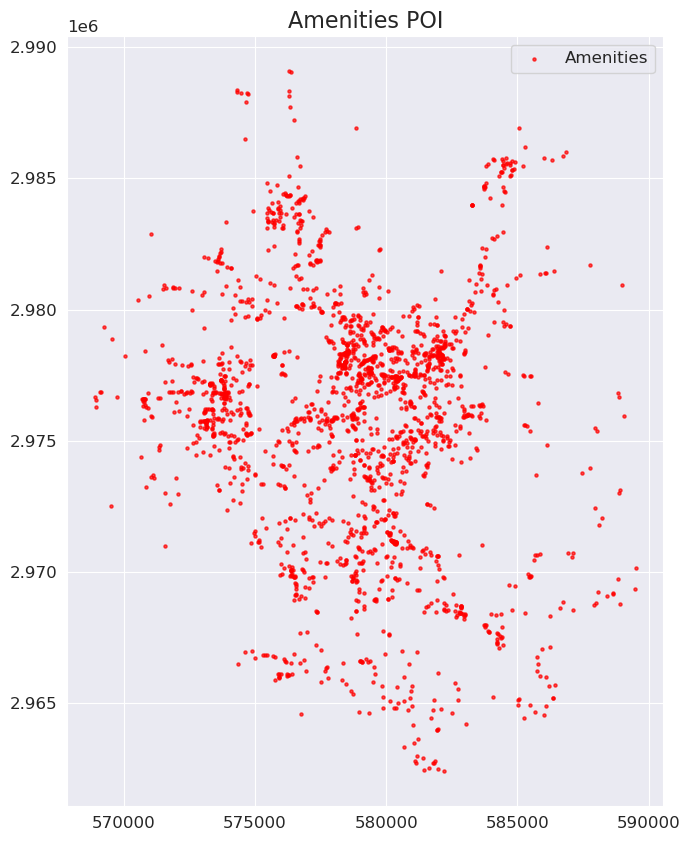

In [22]:
import matplotlib.pyplot as plt

# Plot the amenities data
fig, ax = plt.subplots(figsize=(10, 10))
amenities.plot(ax=ax, color='red', markersize=5, alpha=0.7, label='Amenities')

# Add a title and legend
ax.set_title('Amenities POI', fontsize=16)
ax.legend()

# Show the plot
plt.show()

# 3 Shops Data Download

In [23]:
# Define the tags for shops
shop_tag = {"shop": True}

shops = ox.features.features_from_polygon(polygon, tags=shop_tag)

In [24]:
# Add geometry-type column (Point, Polygon, MultiPolygon …)
shops["geom_type"] = shops.geometry.geom_type

print("\nGeometry type counts:")
print(shops["geom_type"].value_counts(dropna=False))


Geometry type counts:
geom_type
Point      610
Polygon     48
Name: count, dtype: int64


In [25]:
# Apply conversion
shops["geometry"] = shops.geometry.apply(to_point)

# Drop rows where conversion failed
shops = shops[shops.geometry.notnull()].set_geometry("geometry")

In [26]:
shops.head(5)

geometry    addr:housename  \
element id                                                        
node    1338021375  POINT (75.79779 26.94594)  Near Jain Temple   
        1466911304  POINT (75.80911 26.91546)               NaN   
        1466925100  POINT (75.81297 26.91688)               NaN   
        1466925103  POINT (75.81306 26.91693)               NaN   
        1496871951  POINT (75.79369 26.90267)               NaN   

                      addr:street                name         shop  \
element id                                                           
node    1338021375  Shastri Nagar      Relaince Fresh  convenience   
        1466911304            NaN           Book Wise        books   
        1466925100            NaN                 NaN        books   
        1466925103            NaN                 NaN        books   
        1496871951            NaN  metropolitian mall  convenience   

                                                     addr:housenumber  \
element id                                                              
node    1338021375                                                NaN   
        1466911304  17, Station Rd, Hasanpura, Jaipur, Rajasthan 3...   
        1466925100                                                NaN   
        1466925103                                                NaN   
        1496871951                                                NaN   

                   addr:city addr:postcode air_conditioning branch  ...  \
element id                                                          ...   
node    1338021375       NaN           NaN              NaN    NaN  ...   
        1466911304       NaN           NaN              NaN    NaN  ...   
        1466925100       NaN           NaN              NaN    NaN  ...   
        1466925103       NaN           NaN              NaN    NaN  ...   
        1496871951       NaN           NaN              NaN    NaN  ...   

                   contact:mobile addr:place hairdresser building landuse  \
element id                                                                  
node    1338021375            NaN        NaN         NaN      NaN     NaN   
        1466911304            NaN        NaN         NaN      NaN     NaN   
        1466925100            NaN        NaN         NaN      NaN     NaN   
        1466925103            NaN        NaN         NaN      NaN     NaN   
        1496871951            NaN        NaN         NaN      NaN     NaN   

                   layer cuisine service:vehicle:truck_repair  \
element id                                                      
node    1338021375   NaN     NaN                          NaN   
        1466911304   NaN     NaN                          NaN   
        1466925100   NaN     NaN                          NaN   
        1466925103   NaN     NaN                          NaN   
        1496871951   NaN     NaN                          NaN   

                   payment:diners_club geom_type  
element id                                        
node    1338021375                 NaN     Point  
        1466911304                 NaN     Point  
        1466925100                 NaN     Point  
        1466925103                 NaN     Point  
        1496871951                 NaN     Point  

[5 rows x 125 columns]

In [27]:
print(f"Number of records of shops: {shops.shape[0]}")

Number of records of shops: 658


In [28]:
# Transform to Jaipur's CRS EPSG:32643 and export to GeoJSON
shops = shops.to_crs(epsg=32643)
shops.to_file('data/raw/pca/shops_jaipur.geojson', driver='GeoJSON')

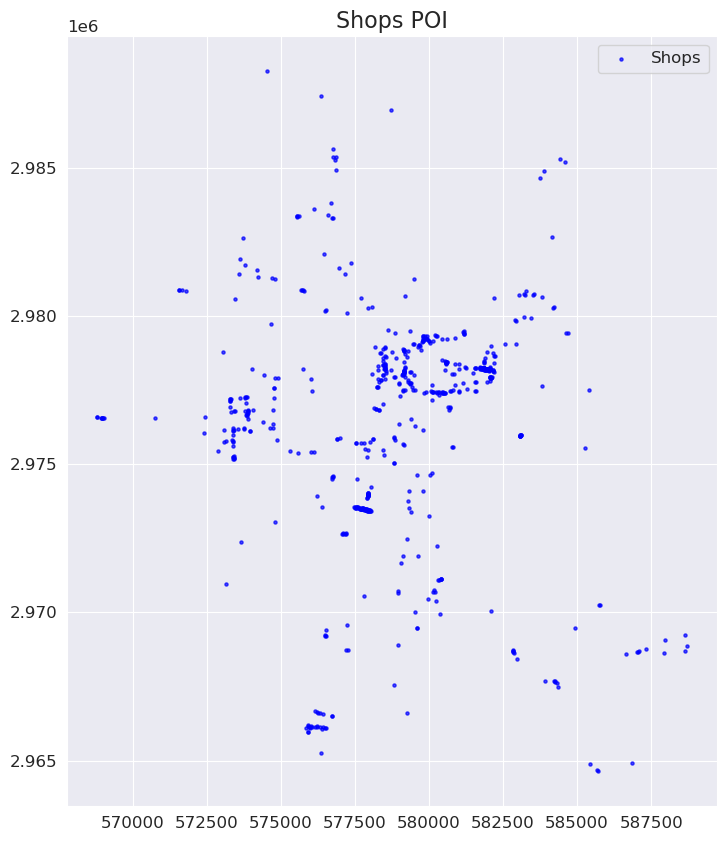

In [29]:
# Plot the shops data
fig, ax = plt.subplots(figsize=(10, 10))
shops.plot(ax=ax, color='blue', markersize=5, alpha=0.7, label='Shops')
# Add a title and legend
ax.set_title('Shops POI', fontsize=16)
ax.legend()
# Show the plot
plt.show()


# 4 Offices Data Download

In [30]:
# Define the tags for offices
office_tag = {"office": True}

offices = ox.features.features_from_polygon(polygon, tags=office_tag)


In [31]:
# Add geometry-type column (Point, Polygon, MultiPolygon …)
offices["geom_type"] = offices.geometry.geom_type
print("\nGeometry type counts:")
print(offices["geom_type"].value_counts(dropna=False))


Geometry type counts:
geom_type
Point      83
Polygon    24
Name: count, dtype: int64


In [32]:
# Apply conversion
offices["geometry"] = offices.geometry.apply(to_point)
# Drop rows where conversion failed
offices = offices[offices.geometry.notnull()].set_geometry("geometry")


In [33]:
offices.head(5)

geometry  \
element id                                      
node    2334207277  POINT (75.79247 26.92732)   
        2702235313   POINT (75.8311 26.88813)   
        2725296788    POINT (75.81261 26.883)   
        2725536805   POINT (75.8141 26.89257)   
        2725536816  POINT (75.81073 26.89622)   

                                                 name  \
element id                                              
node    2334207277                       Collectorate   
        2702235313                    Bhatia Workshop   
        2725296788  RA Poddar Institute of Management   
        2725536805       Jaipur Development Authority   
        2725536816                         RBI Office   

                                     office          addr:city  \
element id                                                       
node    2334207277               government                NaN   
        2702235313                  company  Jaipur, Rajasthan   
        2725296788  educational_institution                NaN   
        2725536805               government                NaN   
        2725536816               government                NaN   

                   addr:housenumber    addr:street             phone  \
element id                                                             
node    2334207277              NaN            NaN               NaN   
        2702235313         6 GHA 49  Jawahar Nagar  +91 978 376 1037   
        2725296788              NaN            NaN               NaN   
        2725536805              NaN            NaN               NaN   
        2725536816              NaN            NaN               NaN   

                   addr:postcode website opening_hours  ... payment:cards  \
element id                                              ...                 
node    2334207277           NaN     NaN           NaN  ...           NaN   
        2702235313           NaN     NaN           NaN  ...           NaN   
        2725296788           NaN     NaN           NaN  ...           NaN   
        2725536805           NaN     NaN           NaN  ...           NaN   
        2725536816           NaN     NaN           NaN  ...           NaN   

                   payment:credit_cards check_date internet_access:fee  \
element id                                                               
node    2334207277                  NaN        NaN                 NaN   
        2702235313                  NaN        NaN                 NaN   
        2725296788                  NaN        NaN                 NaN   
        2725536805                  NaN        NaN                 NaN   
        2725536816                  NaN        NaN                 NaN   

                   name:hi building:levels layer height mobile geom_type  
element id                                                                
node    2334207277     NaN             NaN   NaN    NaN    NaN     Point  
        2702235313     NaN             NaN   NaN    NaN    NaN     Point  
        2725296788     NaN             NaN   NaN    NaN    NaN     Point  
        2725536805     NaN             NaN   NaN    NaN    NaN     Point  
        2725536816     NaN             NaN   NaN    NaN    NaN     Point  

[5 rows x 46 columns]

In [34]:
# Print the number of records
print(f"Number of records of offices: {offices.shape[0]}")

Number of records of offices: 107


In [35]:
# Transform to Jaipur's CRS EPSG:32643 and export to GeoJSON
offices = offices.to_crs(epsg=32643)
offices.to_file('data/raw/pca/offices_jaipur.geojson', driver='GeoJSON')


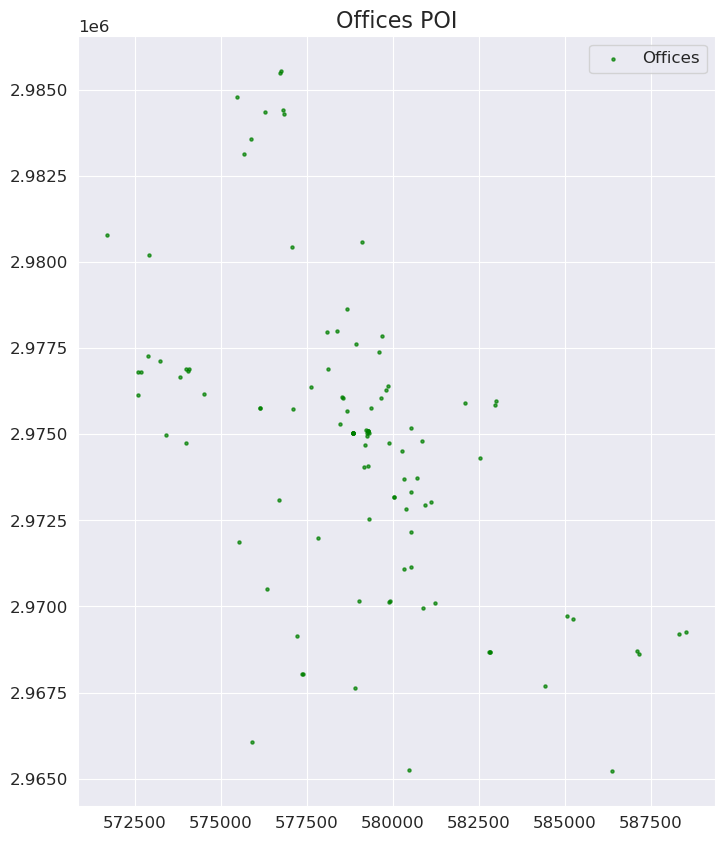

In [36]:
# Plot the offices data
fig, ax = plt.subplots(figsize=(10, 10))
offices.plot(ax=ax, color='green', markersize=5, alpha=0.7, label='Offices')
# Add a title and legend
ax.set_title('Offices POI', fontsize=16)
ax.legend()
# Show the plot
plt.show()


# 5 Transport Stations Data Download

In [37]:
# Define the tags for transport stations
transport_tags = {
    "public_transport": ["station", "stop_area", "stop_area_group",
                         "platform", "stop_position"],

    "railway": ["station", "halt", "tram_stop", "subway_entrance", "platform"],

    "amenity": ["bus_station", "ferry_terminal", "taxi"],
    "highway": ["bus_stop", "taxi_rank"],

    "aeroway": ["aerodrome", "terminal", "gate", "helipad", "heliport"],

}

transport_stations = ox.features.features_from_polygon(polygon, tags=transport_tags)


In [38]:
# Add geometry-type column (Point, Polygon, MultiPolygon …)
transport_stations["geom_type"] = transport_stations.geometry.geom_type
print("\nGeometry type counts:")
print(transport_stations["geom_type"].value_counts(dropna=False))


Geometry type counts:
geom_type
Point         433
Polygon        21
LineString     12
Name: count, dtype: int64


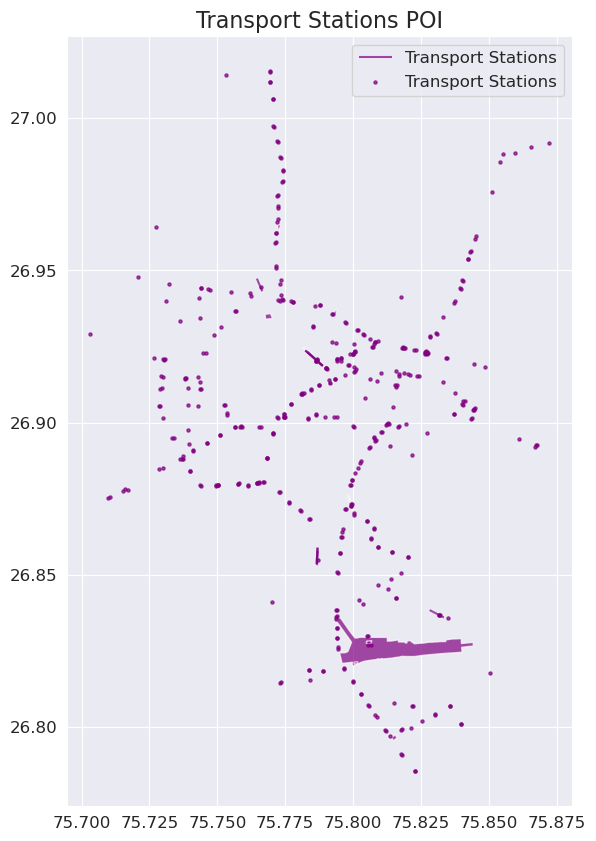

In [39]:
# Plot the transport stations data
fig, ax = plt.subplots(figsize=(10, 10))
transport_stations.plot(ax=ax, color='purple', markersize=5, alpha=0.7, label='Transport Stations')
# Add a title and legend
ax.set_title('Transport Stations POI', fontsize=16)
ax.legend()
plt.savefig('image/process/02_01 raw_transport_stations_problem_jaipur.png', dpi=300, bbox_inches='tight')
# Show the plot
plt.show()


Since airport is a large area, it is not suitable for point representation.So I decide to make two datasets of the transport stations, only for point and linestring features and for polygon features.

In [40]:
# Split the transport stations into polygons and points
poly_mask = transport_stations.geometry.geom_type.isin(["Polygon", "MultiPolygon"])
poly_gdf  = transport_stations[poly_mask].copy()
pt_gdf    = transport_stations[~poly_mask].copy()        # Point + Line geometries

In [41]:
pt_gdf["geometry"] = pt_gdf.geometry.apply(to_point)
pt_gdf = pt_gdf.set_geometry("geometry")

In [42]:
# Print the number of records
print(f"Number of records of transport stations (points): {pt_gdf.shape[0]}")
print(f"Number of records of transport stations (polygon): {poly_gdf.shape[0]}")


Number of records of transport stations (points): 445
Number of records of transport stations (polygon): 21


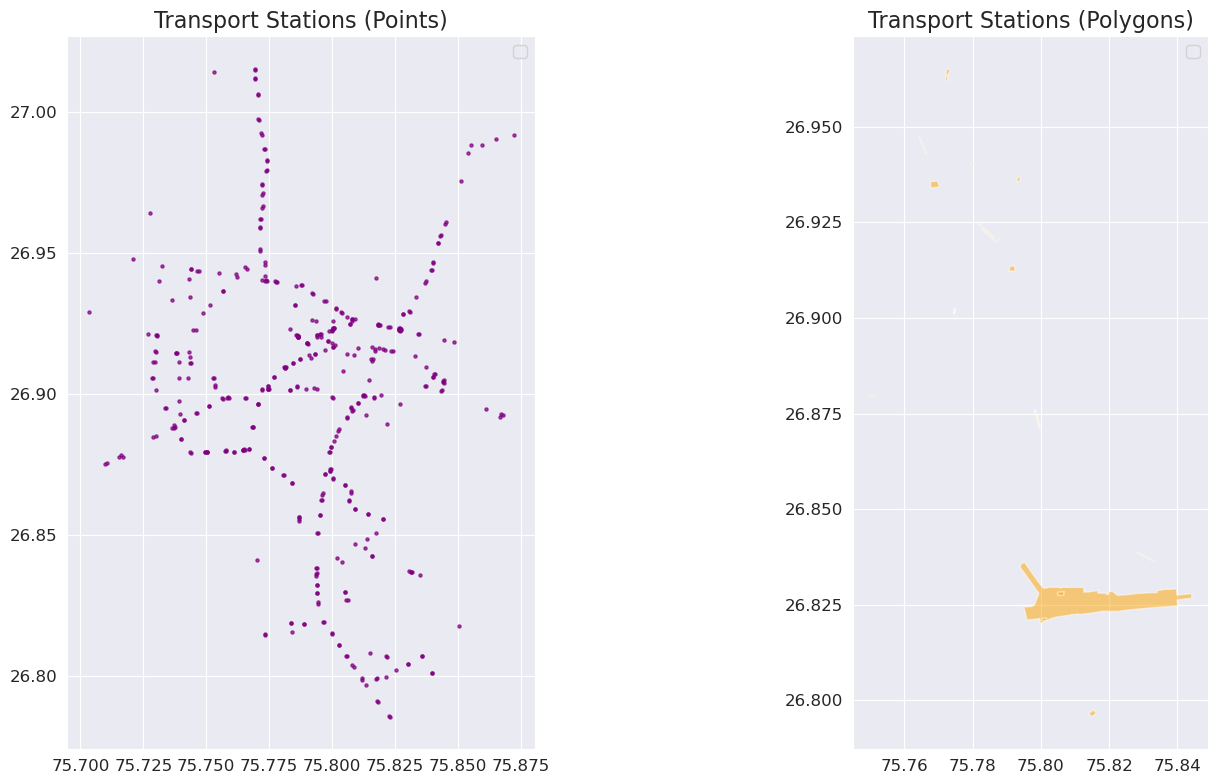

In [43]:
# Plot both point and polygon transport stations
import matplotlib.pyplot as plt

# Create subplots for points and polygons
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Plot point transport stations
pt_gdf.plot(ax=axes[0], color='purple', markersize=5, alpha=0.7)
axes[0].set_title('Transport Stations (Points)', fontsize=16)
axes[0].legend()

# Plot polygon transport stations
poly_gdf.plot(ax=axes[1], color='orange', alpha=0.5)
axes[1].set_title('Transport Stations (Polygons)', fontsize=16)
axes[1].legend()

# Adjust layout and show the plots
plt.tight_layout()
plt.savefig('image/process/02_01_transport_stations_separated_jaipur.png', dpi=300, bbox_inches='tight')
plt.show()

In [44]:
# Transform to Jaipur's CRS EPSG:32643 and export to GeoJSON
pt_gdf = pt_gdf.to_crs(epsg=32643)
poly_gdf = poly_gdf.to_crs(epsg=32643)
pt_gdf.to_file('data/raw/pca/transport_stations_points_jaipur.geojson', driver='GeoJSON')
poly_gdf.to_file('data/raw/pca/transport_stations_polygons_jaipur.geojson', driver='GeoJSON')


In [45]:
aoi.head(5)

,Id,Area,Ward_No,POP,DENS_PPH,NAME,assembly,jmc,X,Y,lon,lat,geometry
0,1,502,1,11930,24,VIDHYADHAR NAGAR,VidyadharNgr_Assembly,150,574626.431817,2.988687e+06,75.752277,27.018317,"MULTIPOLYGON (((75.69536 26.93604, 75.69536 26..."


In [46]:
# Transform the AOI to shapefile
# Export the AOI to a shapefile
aoi.to_file('data/raw/JMC_union_shapefile.shp', driver='ESRI Shapefile')